# CFB Prediction Model

##  Import Libraries and set up API

In [ ]:
pip install scipy

In [1]:
import cfbd 
import pandas as pd
import numpy as np
import flatdict
import matplotlib as mpl
from sklearn.model_selection import train_test_split

#exploratory visualizatiion
import matplotlib.pyplot as plt
import seaborn as sns

#used for RandomForest feature selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder #also used for pipelines below
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import make_column_selector as selector


#used for pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#used for models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC, LinearSVR, SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)


#used for model testing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score,  accuracy_score



pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

CFBD_API_KEY = ('Bearer hzFFDvdPyU9BZQdRN6qgwajAPggVaj8k3YvzcFsFP/h9/dpM/LY0K7P6oKb3JiCn')

In [2]:
config = cfbd.Configuration()
config.api_key['Authorization']= CFBD_API_KEY
api = cfbd.StatsApi(cfbd.ApiClient(config))
teamapi = cfbd.TeamsApi(cfbd.ApiClient(config))
ratingsapi = cfbd.RatingsApi(cfbd.ApiClient(config))

In [3]:
#Converts data type to Pandas dictionaries

def generate_advanced_team_season_stats_df(year):
    
    #grab the advancated teams data
    season = api.get_advanced_team_season_stats(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    season_df_data = dict()
    
    for season in season:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        season_dict = season.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_season_dict = flatdict.FlatDict(season_dict, delimiter='.')
        
        for k, v in flattened_season_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in season_df_data:
                season_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            season_df_data[k].append(v)
            
    return pd.DataFrame(season_df_data)

In [4]:
def generate_team_talent_df(year):
    
    #grab the advancated teams data
    talent = teamapi.get_talent(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    talent_df_data = dict()
    
    for talent in talent:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        talent_dict = talent.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_talent_dict = flatdict.FlatDict(talent_dict, delimiter='.')
        
        for k, v in flattened_talent_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in talent_df_data:
                talent_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            talent_df_data[k].append(v)
            
    return pd.DataFrame(talent_df_data)

In [5]:
def generate_SRS(year):
    
    #grab the advancated teams data
    SRS = ratingsapi.get_srs_ratings(year=year)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    srs_df_data = dict()
    
    for SRS in SRS:
        #convert the season object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        SRS_dict = SRS.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_srs_dict = flatdict.FlatDict(SRS_dict, delimiter='.')
        
        for k, v in flattened_srs_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in srs_df_data:
                srs_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            srs_df_data[k].append(v)
            
    return pd.DataFrame(srs_df_data)

In [6]:
srs24 = generate_SRS(2024)
srs24.head()

,year,team,conference,division,rating,ranking
0,2024,Ohio State,Big Ten,None,24.6,1.0
1,2024,Georgia,SEC,None,20.7,2.0
2,2024,Alabama,SEC,None,20.6,3.0
3,2024,Indiana,Big Ten,None,20.2,4.0
4,2024,Texas,SEC,None,19.6,5.0


In [7]:
talent24 = generate_team_talent_df(2024)
talent24 = talent24.sort_values('school')

#rename column for merge later
talent24.rename(columns={'school':'team'}, inplace=True)

#view new df
talent24.head(5)

,year,team,talent
132,2024,Air Force,0.00
101,2024,Akron,537.82
0,2024,Alabama,1018.28
83,2024,App State,575.31
55,2024,Arizona,672.70


In [8]:
#Sets metrics to use for predictive model
metrics = ['team','offense.ppa','offense.success_rate', 'offense.explosiveness','offense.power_success','offense.stuff_rate','offense.points_per_opportunity','offense.havoc.total','defense.ppa','defense.success_rate', 'defense.explosiveness','defense.power_success','defense.stuff_rate','defense.points_per_opportunity', 'defense.havoc.total']

In [9]:
#view updated dataframe with isolated metrics
stats24 = generate_advanced_team_season_stats_df(year=2024)
stats24 = stats24[metrics]
stats24.head(5)

,team,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total
0,Air Force,0.063633,0.354839,1.138066,0.789474,0.159664,4.120000,0.146237,0.212848,0.429245,1.240028,0.641026,0.167300,4.095238,0.129717
1,Akron,0.027492,0.384774,1.221499,0.833333,0.219388,2.852941,0.183128,0.241403,0.463899,1.229826,0.764706,0.190164,4.375000,0.144404
2,Alabama,0.301132,0.460317,1.376259,0.787879,0.216418,4.807692,0.148810,0.040426,0.355786,1.243222,0.666667,0.185430,3.022222,0.183074
3,App State,0.172066,0.439216,1.296218,0.791667,0.168142,3.976744,0.174510,0.351170,0.495238,1.289318,0.785714,0.131148,5.270270,0.114286
4,Arizona,0.146295,0.391389,1.436205,0.551724,0.269231,3.577778,0.156556,0.159123,0.418605,1.230374,0.783784,0.171875,4.369565,0.133721


In [10]:
statsmerged = pd.merge(talent24, stats24, on='team')

statsmerged = statsmerged.drop(['year'], axis=1)
statsmerged2 = pd.merge(statsmerged, srs24, on='team')
statsmerged2 = statsmerged2.drop(['year','conference','division','ranking'],axis=1)                
statsmerged2.head(5)

,team,talent,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total,rating
0,Air Force,0.00,0.063633,0.354839,1.138066,0.789474,0.159664,4.120000,0.146237,0.212848,0.429245,1.240028,0.641026,0.167300,4.095238,0.129717,-21.4
1,Akron,537.82,0.027492,0.384774,1.221499,0.833333,0.219388,2.852941,0.183128,0.241403,0.463899,1.229826,0.764706,0.190164,4.375000,0.144404,-17.9
2,Alabama,1018.28,0.301132,0.460317,1.376259,0.787879,0.216418,4.807692,0.148810,0.040426,0.355786,1.243222,0.666667,0.185430,3.022222,0.183074,20.6
3,App State,575.31,0.172066,0.439216,1.296218,0.791667,0.168142,3.976744,0.174510,0.351170,0.495238,1.289318,0.785714,0.131148,5.270270,0.114286,-11.3
4,Arizona,672.70,0.146295,0.391389,1.436205,0.551724,0.269231,3.577778,0.156556,0.159123,0.418605,1.230374,0.783784,0.171875,4.369565,0.133721,-2.7


## Team variable creation

In [11]:
#sperates each row of dictionary into a new dataframe and stores in dictionary
def separate_rows_to_dataframes(df):
    # Dictionary to hold the new DataFrames
    dataframes = {}
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the team name to use as the variable name
        team_name = row['team']
        
        # Create a new DataFrame for the current row
        new_df = pd.DataFrame([row])
        
        new_df = new_df.drop(['team'], axis = 1)
        
        # Store the new DataFrame in the dictionary
        dataframes[team_name] = new_df
    
    return dataframes

separated_dfs = separate_rows_to_dataframes(statsmerged2)

In [12]:
# save each team df from dictionary as variable
AirForce = separated_dfs.get('Air Force')
Akron = separated_dfs.get('Akron')
Alabama = separated_dfs.get('Alabama')
AppState = separated_dfs.get('App State')
Arizona = separated_dfs.get('Arizona')
ArizonaState = separated_dfs.get('Arizona State')
Arkansas = separated_dfs.get('Arkansas')
ArkansasState = separated_dfs.get('Arkansas State')
Army = separated_dfs.get('Army')
Auburn = separated_dfs.get('Auburn')
BallState = separated_dfs.get('Ball State')
Baylor = separated_dfs.get('Baylor')
BoiseState = separated_dfs.get('Boise State')
BostonCollege = separated_dfs.get('Boston College')
BowlingGreen = separated_dfs.get('Bowling Green')
Buffalo = separated_dfs.get('Buffalo')
BYU = separated_dfs.get('BYU')
California = separated_dfs.get('California')
CentralMichigan = separated_dfs.get('Central Michigan')
Charlotte = separated_dfs.get('Charlotte')
Cincinnati = separated_dfs.get('Cincinnati')
Clemson = separated_dfs.get('Clemson')
CoastalCarolina = separated_dfs.get('Coastal Carolina')
Colorado = separated_dfs.get('Colorado')
ColoradoState = separated_dfs.get('Colorado State')
Duke = separated_dfs.get('Duke')
EastCarolina = separated_dfs.get('East Carolina')
EasternMichigan = separated_dfs.get('Eastern Michigan')
Florida = separated_dfs.get('Florida')
FloridaAtlantic = separated_dfs.get('Florida Atlantic')
FloridaInternational = separated_dfs.get('Florida International')
FloridaState = separated_dfs.get('Florida State')
FresnoState = separated_dfs.get('Fresno State')
Georgia = separated_dfs.get('Georgia')
GeorgiaSouthern = separated_dfs.get('Georgia Southern')
GeorgiaState = separated_dfs.get('Georgia State')
GeorgiaTech = separated_dfs.get('Georgia Tech')
Houston = separated_dfs.get('Houston')
Illinois = separated_dfs.get('Illinois')
Indiana = separated_dfs.get('Indiana')
Iowa = separated_dfs.get('Iowa')
IowaState = separated_dfs.get('Iowa State')
JacksonvilleState = separated_dfs.get('Jacksonville State')
JamesMadison = separated_dfs.get('James Madison')
Kansas = separated_dfs.get('Kansas')
KansasState = separated_dfs.get('Kansas State')
KentState = separated_dfs.get('Kent State')
Kentucky = separated_dfs.get('Kentucky')
Liberty = separated_dfs.get('Liberty')
Louisiana = separated_dfs.get('Louisiana')
LouisianaTech = separated_dfs.get('Louisiana Tech')
Louisville = separated_dfs.get('Louisville')
LSU = separated_dfs.get('LSU')
Marshall = separated_dfs.get('Marshall')
Maryland = separated_dfs.get('Maryland')
Massachusetts = separated_dfs.get('Massachusetts')
Memphis = separated_dfs.get('Memphis')
Miami = separated_dfs.get('Miami')
Michigan = separated_dfs.get('Michigan')
MichiganState = separated_dfs.get('Michigan State')
MiddleTennessee = separated_dfs.get('Middle Tennessee')
Minnesota = separated_dfs.get('Minnesota')
MississippiState = separated_dfs.get('Mississippi State')
Missouri = separated_dfs.get('Missouri')
Navy = separated_dfs.get('Navy')
NCState = separated_dfs.get('NC State')
Nebraska = separated_dfs.get('Nebraska')
Nevada = separated_dfs.get('Nevada')
NewMexico = separated_dfs.get('New Mexico')
NewMexicoState = separated_dfs.get('New Mexico State')
NorthCarolina = separated_dfs.get('North Carolina')
NIU = separated_dfs.get('Northern Illinois')
NorthTexas = separated_dfs.get('North Texas')
Northwestern = separated_dfs.get('Northwestern')
NotreDame = separated_dfs.get('Notre Dame')
Ohio = separated_dfs.get('Ohio')
OhioState = separated_dfs.get('Ohio State')
Oklahoma = separated_dfs.get('Oklahoma')
OklahomaState = separated_dfs.get('Oklahoma State')
OldDominion = separated_dfs.get('Old Dominion')
OleMiss = separated_dfs.get('Ole Miss')
Oregon = separated_dfs.get('Oregon')
OregonState = separated_dfs.get('Oregon State')
PennState = separated_dfs.get('Penn State')
Pittsburgh = separated_dfs.get('Pittsburg')
Purdue = separated_dfs.get('Purdue')
Rice = separated_dfs.get('Rice')
Rutgers = separated_dfs.get('Rutgers')
SamHouston = separated_dfs.get('Sam Houston')
SanDiegoState = separated_dfs.get('San Diego State')
SanJoseState = separated_dfs.get('San Jose State')
SMU = separated_dfs.get('SMU')
SouthAlabama = separated_dfs.get('South Alabama')
SouthCarolina = separated_dfs.get('South Carolina')
SouthernMiss = separated_dfs.get('Southern Miss')
SouthFlorida = separated_dfs.get('SouthFlorida')
Stanford = separated_dfs.get('Stanford')
Syracuse = separated_dfs.get('Syracuse')
TCU = separated_dfs.get('TCU')
Temple = separated_dfs.get('Temple')
Tennessee = separated_dfs.get('Tennessee')
Texas = separated_dfs.get('Texas')
TexasAM = separated_dfs.get('Texas A&M')
TexasState = separated_dfs.get('Texas State')
TexasTech = separated_dfs.get('Texas Tech')
Toledo = separated_dfs.get('Toldo')
Troy = separated_dfs.get('Troy')
Tulane = separated_dfs.get('Tulane')
Tulsa = separated_dfs.get('Tulsa')
UAB = separated_dfs.get('UAB')
UCF = separated_dfs.get('UCF')
UCLA = separated_dfs.get('UCLA')
UConn = separated_dfs.get('UConn')
ULMonroe = separated_dfs.get('UL Monroe')
UNLV = separated_dfs.get('UNLV')
USC = separated_dfs.get('USC')
Utah = separated_dfs.get('Utah')
UtahState = separated_dfs.get('Utah State')
UTEP = separated_dfs.get('UTEP')
UTSA = separated_dfs.get('UTSA')
Vanderbilt = separated_dfs.get('Vanderbilt')
Virginia = separated_dfs.get('Virginia')
VirginiaTech = separated_dfs.get('Virginia Tech')
WakeForest = separated_dfs.get('Wake Forest')
Washington = separated_dfs.get('Washington')
WashingtonState = separated_dfs.get('Washington State')
WesternKentucky = separated_dfs.get('Western Kentucky')
WesternMichigan = separated_dfs.get('Western Michigan')
WestVirginia = separated_dfs.get('West Virginia')
Wisconsin = separated_dfs.get('Wisconsin')
Wyoming = separated_dfs.get('Wyoming')

In [13]:
Georgia.head()

,talent,offense.ppa,offense.success_rate,offense.explosiveness,offense.power_success,offense.stuff_rate,offense.points_per_opportunity,offense.havoc.total,defense.ppa,defense.success_rate,defense.explosiveness,defense.power_success,defense.stuff_rate,defense.points_per_opportunity,defense.havoc.total,rating
34,1006.89,0.27978,0.454741,1.320279,0.675676,0.212121,4.727273,0.140086,0.056059,0.36092,1.216355,0.75,0.213592,3.057143,0.17931,20.7


## Classification Models

In [14]:
#Load Data
CFB = pd.read_csv("CFBNewTransformedCopy.csv", encoding='unicode_escape')

In [15]:
#Get target feature and predicting features
target = CFB['Outcome']
CFB_features = CFB.drop(['Team','Opponent','PD','Outcome'], axis=1)
#Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(CFB_features, target, test_size=0.2, random_state=42)

#recombine data for EDA
CFB_train = pd.concat([X_train, y_train], axis=1)

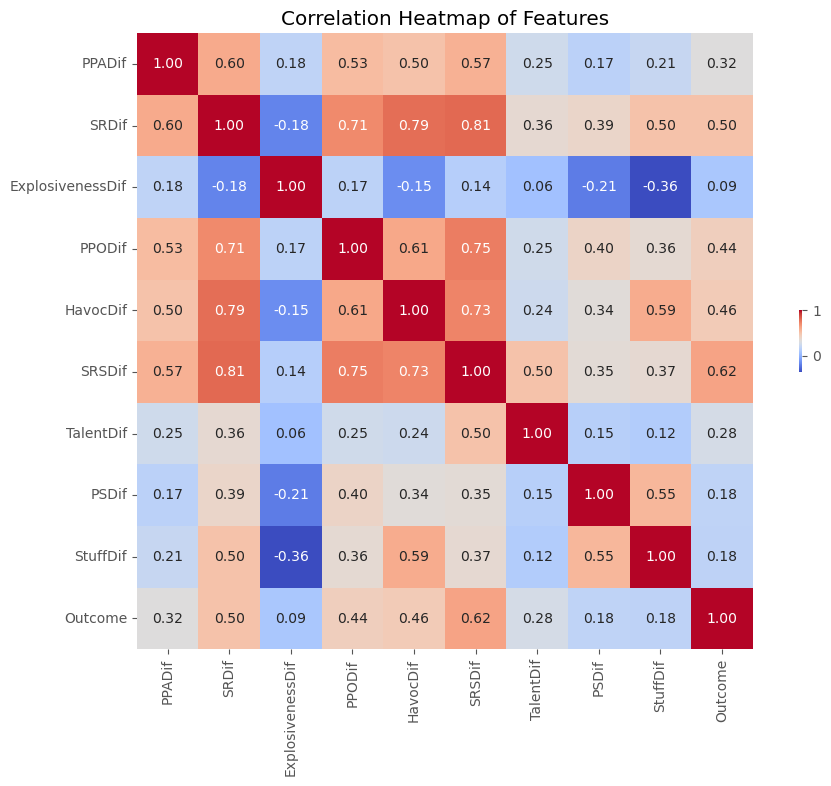

PPADif              0.323095
SRDif               0.500897
ExplosivenessDif    0.094519
PPODif              0.435180
HavocDif            0.458574
SRSDif              0.624688
TalentDif           0.277287
PSDif               0.181313
StuffDif            0.177239
Outcome             1.000000
Name: Outcome, dtype: float64


In [16]:
plt.figure(figsize=(12, 8))
correlation_matrix = CFB_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .1})
plt.title('Correlation Heatmap of Features')
plt.show()

print(correlation_matrix['Outcome'])

### Preprocess Data

In [17]:
#scale data (needed for svm and stack models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###  XGBoost Model

In [18]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # binary classification
    max_depth=2,             # Maximum tree depth
    learning_rate=0.1,           # Learning rate
    n_estimators=50,          # Number of boosting rounds
    subsample=.8,
    min_child_weight =1,
    colsample_bytree=1,
    eval_metric='error',# Evaluation metric 
)

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
#evaluate training data
cv_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring="f1")
cv_xgbp = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring="precision")
print('XGB Cross Validation F1 Score:',cv_xgb.mean())
print('XGB Cross Validation Precision Score:',cv_xgbp.mean())

#make predicitions
xgbclass_pred = xgb_classifier.predict(X_test)

# Evaluate testing data
xgb_classf1 = f1_score(y_test, xgbclass_pred)
xgb_classprecision = precision_score(y_test, xgbclass_pred)
print('XGB F1 score:', xgb_classf1)
print('XGB Precison score:',xgb_classprecision)

XGB Cross Validation F1 Score: 0.8067894279244904
XGB Cross Validation Precision Score: 0.7629432335465711
XGB F1 score: 0.8633879781420766
XGB Precison score: 0.8681318681318682


### SVM Classifier

In [20]:
svm = LinearSVC(C=1, max_iter=10_000, dual='auto', random_state=42)
    
svm.fit(X_train, y_train)

LinearSVC(C=1, dual='auto', max_iter=10000, random_state=42)

In [21]:
cv_svm = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1")
cv_svm = cross_val_score(svm, X_train, y_train, cv=5, scoring="precision")
print('SVM Cross Val F1:', cv_svm.mean())
print('SVM Cross Val Precision:',cv_svm.mean())

#make predicitions
svm_pred = svm.predict(X_test)

# Evaluate testing data
svm_classf1 = f1_score(y_test, svm_pred)
svm_classprecision = precision_score(y_test, svm_pred)
print('SVM F1 score:', svm_classf1)
print('SVM Precison score:',svm_classprecision)

SVM Cross Val F1: 0.7965505820309987
SVM Cross Val Precision: 0.7965505820309987
SVM F1 score: 0.8633879781420766
SVM Precison score: 0.8681318681318682


## Logistic Model

In [22]:
log = LogisticRegression()

log.fit(X_train, y_train)

LogisticRegression()

In [23]:
#evaluate training data
log_cvf1 = cross_val_score(log, X_train, y_train, cv=5, scoring="f1")
log_cvp = cross_val_score(log, X_train, y_train, cv=5, scoring="precision")
print('Log Cross Validation F1 Score:',log_cvf1.mean())
print('Log Cross Validation Precision Score:',log_cvp.mean())

Log Cross Validation F1 Score: 0.8174486143685243
Log Cross Validation Precision Score: 0.7970328449780505


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
log_pred = log.predict(X_test)

# Evaluate testing data
logf1 = f1_score(y_test, log_pred)
logprecision = precision_score(y_test, log_pred)
print('Log F1 score:', logf1)
print('Log Precison score:',logprecision)

# Evaluate the model
accuracy = accuracy_score(y_test, log_pred)
conf_matrix = confusion_matrix(y_test, log_pred)
class_report = classification_report(y_test, log_pred)

# Print results)
print('Classification Report:')
print(class_report)

Log F1 score: 0.861878453038674
Log Precison score: 0.8764044943820225
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        57
           1       0.88      0.85      0.86        92

    accuracy                           0.83       149
   macro avg       0.82      0.83      0.82       149
weighted avg       0.83      0.83      0.83       149



## KNN Model

In [25]:
k = 25  # You can change k to any other integer
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

In [26]:
#evaluate training data
knn_cvf1 = cross_val_score(knn, X_train, y_train, cv=5, scoring="f1")
knn_cvp = cross_val_score(knn, X_train, y_train, cv=5, scoring="precision")
print('KNN Cross Validation F1 Score:',knn_cvf1.mean())
print('KNN Cross Validation Precision Score:',knn_cvp.mean())

KNN Cross Validation F1 Score: 0.8020156265190195
KNN Cross Validation Precision Score: 0.7567324429333562


In [27]:
rbf_model = SVC(kernel='rbf', gamma='scale')  # You can adjust gamma as needed

# Fit the model
rbf_model.fit(X_train, y_train)

# Make predictions 
rbfpred = rbf_model.predict(X_test)


# Evaluate the model
print("SVM Model Evaluation:")
print(confusion_matrix(y_test, rbfpred))
print(classification_report(y_test, rbfpred))

SVM Model Evaluation:
[[44 13]
 [15 77]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        57
           1       0.86      0.84      0.85        92

    accuracy                           0.81       149
   macro avg       0.80      0.80      0.80       149
weighted avg       0.81      0.81      0.81       149



## Stacked Model

In [28]:
from sklearn.ensemble import StackingClassifier

stacked_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_classifier),
        ('svm', svm),
        ('log', log),
        ('knn', knn),
        ('rbf', rbf_model)
    ],
    final_estimator=log,
    cv=5  # number of cross-validation folds
)

# Fit the stacking regressor
stacked_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='error',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('svm',
                                LinearSVC(C=1, dual='auto', max_iter=10000,
                                          random_state=42)),
                               ('log', LogisticRegression()),
                               ('knn', KNeighborsClassifier(n_neighbors=25)),
                               ('rbf', SVC())],
                   final_estimator=LogisticRegression())

In [29]:
#evaluate training data
stack_cvf1 = cross_val_score(stacked_clf, X_train, y_train, cv=5, scoring="f1")
stack_cvp = cross_val_score(stacked_clf, X_train, y_train, cv=5, scoring="precision")
print('Stack CV F1 Score:',stack_cvf1.mean())
print('Stack CV Precision Score:',stack_cvp.mean())

# Make predictions
stack_pred = stacked_clf.predict(X_test)

# Evaluate the model
stack_f1 = f1_score(y_test,  stack_pred)
precision_stack = precision_score(y_test, stack_pred)
class_report = classification_report(y_test, stack_pred)

print('Stack F1 Score:',stack_f1)
print('Stack Precision Score:',precision_stack)

print('Classification Report:')
print(class_report)


Stack CV F1 Score: 0.8173265583337527
Stack CV Precision Score: 0.7915949752569471
Stack F1 Score: 0.868131868131868
Stack Precision Score: 0.8777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        57
           1       0.88      0.86      0.87        92

    accuracy                           0.84       149
   macro avg       0.83      0.83      0.83       149
weighted avg       0.84      0.84      0.84       149



### Predictions

In [42]:
# Function to make predictions
def outcome_predict(list1, list2):  
    new_column_names = ['tr','oppa','osr','oexplosive','op','os',
                        'oppo','ohavoc','dppa','dsr','dexplosive',
                        'dp','ds','dppo','dhavoc','srs']

    for df in list2:
        if len(new_column_names) != len(df.columns):
            raise ValueError("Length of new_column_names must match the number of columns in each DataFrame in list2.")

    # Rename columns for DataFrames in list2
    renamed_list2 = [df.rename(columns=dict(zip(df.columns, new_column_names))) for df in list2]
    
    # Ensure both lists have the same number of DataFrames
    if len(list1) != len(renamed_list2):
        raise ValueError("Both lists must have the same number of DataFrames.")

    # Combine the DataFrames horizontally and ensure matching indices
    combined_list = []
    for df1, df2 in zip(list1, renamed_list2):
        if len(df1) != len(df2):
            raise ValueError("DataFrames must have the same number of rows to combine horizontally.")
        combined_list.append(pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1))
    
    # Concatenate all combined DataFrames into a single DataFrame
    final_combined_df = pd.concat(combined_list, ignore_index=True)
    
    
    #Feature engineering to reduce features from 20 to 5
    final_combined_df['PPA'] = final_combined_df['offense.ppa'] + final_combined_df['dppa']
    final_combined_df['SR'] = final_combined_df['offense.success_rate'] + final_combined_df['dsr']
    final_combined_df['Explosiveness'] = final_combined_df['offense.explosiveness'] + final_combined_df['dexplosive']
    final_combined_df['PPO'] = final_combined_df['offense.points_per_opportunity'] + final_combined_df['dppo']
    final_combined_df['Havoc'] = final_combined_df['defense.havoc.total'] + final_combined_df['ohavoc']
    final_combined_df['PS'] = final_combined_df['offense.power_success'] + final_combined_df['dp']
    final_combined_df['Stuff'] = final_combined_df['defense.stuff_rate'] + final_combined_df['os']
    
    
    final_combined_df['PPA1'] = final_combined_df['oppa'] + final_combined_df['defense.ppa']
    final_combined_df['SR1'] = final_combined_df['osr'] + final_combined_df['defense.success_rate']
    final_combined_df['Explosiveness1'] = final_combined_df['oexplosive'] + final_combined_df['defense.explosiveness']
    final_combined_df['PPO1'] = final_combined_df['oppo'] + final_combined_df['defense.points_per_opportunity']
    final_combined_df['Havoc1'] = final_combined_df['dhavoc'] + final_combined_df['offense.havoc.total']
    final_combined_df['PS1'] = final_combined_df['op'] + final_combined_df['defense.power_success']
    final_combined_df['Stuff1'] = final_combined_df['ds'] + final_combined_df['offense.stuff_rate'] 
    
    final_combined_df['PPADif'] = final_combined_df['PPA']-final_combined_df['PPA1']
    final_combined_df['SRDif'] = final_combined_df['SR']-final_combined_df['SR1']
    final_combined_df['ExplosivenessDif'] = final_combined_df['Explosiveness']-final_combined_df['Explosiveness1']
    final_combined_df['PPODif'] = final_combined_df['PPO']-final_combined_df['PPO1']
    final_combined_df['HavocDif'] = final_combined_df['Havoc']-final_combined_df['Havoc1']
    final_combined_df['SRSDif'] = final_combined_df['rating'] - final_combined_df['srs']
    final_combined_df['TalentDif'] = final_combined_df['talent'] - final_combined_df['tr']
    final_combined_df['PSDif'] = final_combined_df['PS'] - final_combined_df['PS1']
    final_combined_df['StuffDif'] = final_combined_df['Stuff'] - final_combined_df['Stuff1']
    
    final_combined_df = final_combined_df.drop(['offense.ppa','offense.success_rate','offense.explosiveness','offense.points_per_opportunity','offense.havoc.total',
                                               'defense.ppa','defense.success_rate','defense.explosiveness','defense.points_per_opportunity', 'defense.havoc.total',
                                               'oppa','osr','oexplosive','oppo','ohavoc','dppa','dsr','dexplosive','dppo','dhavoc',
                                               'PPA', 'SR', 'Explosiveness','PPO','Havoc','Stuff','Stuff1','PS','PS1','dp','ds','op','os',
                                                'offense.power_success', 'defense.power_success','offense.stuff_rate','defense.stuff_rate',
                                                'rating','tr','srs','talent',
                                               'PPA1', 'SR1', 'Explosiveness1','PPO1','Havoc1',],axis=1)
     #scale prediction
    predict_scaled = scaler.transform(final_combined_df)
    
    # Make predictions    
    svmpredictions = svm.predict(predict_scaled)
    xgbpredictions = xgb_classifier.predict(predict_scaled)
    stackedpredictions = stacked_clf.predict(predict_scaled)
    logpredictions = log.predict(predict_scaled)
    
    numeric_cols = final_combined_df.select_dtypes(include='number').columns
    
    final_combined_df = final_combined_df.drop(columns=numeric_cols)
    # Add predictions to the combined DataFrame
    final_combined_df['Team'] = ['Arkansas','PennState','Miami','Minnesota','Purdue','Auburn','Georgia','Oregon','TexasTech','Arizona','Clemson','Wisconsin','SouthCarolina','VT']
    final_combined_df['Opponent'] = ['OleMiss','OhioState','Duke','Illinois','Northwestern','Vanderbilt','Florida','Michigan','IowaState','UCF','Louisville','Iowa','TexasAM','Syra']

    final_combined_df['SVM Predictions'] = svmpredictions
    final_combined_df['XGB Predictions'] = xgbpredictions
    final_combined_df['Stack Predictions'] = stackedpredictions
    final_combined_df['Log Predicitions'] = logpredictions
    
    return final_combined_df

In [43]:
teams = [Arkansas,PennState,Miami,Minnesota,Purdue,Auburn,Georgia,Oregon,TexasTech,Arizona,Clemson,Wisconsin,SouthCarolina,VirginiaTech]
opponents = [OleMiss,OhioState,Duke,Illinois,Northwestern,Vanderbilt,Florida,Michigan,IowaState,UCF,Louisville,Iowa,TexasAM,Syracuse]

In [44]:
outcome_predict(teams, opponents)

,Team,Opponent,SVM Predictions,XGB Predictions,Stack Predictions,Log Predicitions
0,Arkansas,OleMiss,0,0,0,0
1,PennState,OhioState,0,0,0,0
2,Miami,Duke,1,1,1,1
3,Minnesota,Illinois,1,1,1,1
4,Purdue,Northwestern,0,0,0,0
5,Auburn,Vanderbilt,0,0,0,0
6,Georgia,Florida,1,1,1,1
7,Oregon,Michigan,1,1,1,1
8,TexasTech,IowaState,0,0,0,0
9,Arizona,UCF,0,0,0,0
